In [1]:
!pip install -q --no-index $(find /kaggle/input/sennet-wheels -name '*.whl')
!pip install -q --no-index --find-links=/kaggle/input/angionet-snapshot/snapshot angionet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.33.12 which is incompatible.


In [2]:
import gc
from pathlib import Path

import albumentations as A
import albumentations.pytorch as AP
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision.utils import make_grid

from angionet.core import predict
from angionet.functional import decode, encode, standardize, rescale
from angionet.postprocessing import remove_dust
from angionet.utils import cleanup, set_seed
from angionet.datasets import InferenceDataset
from angionet.postprocessing import (
    TestTimeAugmentations, 
    HorizontalFlip, 
    VerticalFlip, 
    Rotate90,
    apply_threshold,
    fill_holes
)

from albumentations.core.transforms_interface import ImageOnlyTransform

class Rescale(ImageOnlyTransform):
    def __init__(self, always_apply = True, p = 1):
        super().__init__(always_apply = always_apply, p = p)

    def apply(self, image, **kwargs):
        image = (image - image.min()) / (image.max() - image.min())
        return np.asarray(image, dtype = 'float32')
    
class AdaptiveSquarePad(ImageOnlyTransform):
    def __init__(self, divisible = 32, border_mode = 'reflect', always_apply = True, p = 1):
        super().__init__(always_apply = always_apply, p = p)
        self.divisible = divisible
        self.border_mode = border_mode
        
    def apply(self, image, **kwargs):
        H, W = image.shape
        pad = max(
            H + self.divisible - H % self.divisible, 
            W + self.divisible - W % self.divisible
        )
        image = np.pad(image, ((0, pad - H), (0, pad - W)), mode = self.border_mode)
        return image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class config:
    seed = 42
    root = "/kaggle/input/blood-vessel-segmentation"
    model = list(Path("/kaggle/input/angionet-snapshot").glob("*.pt"))[0]
    thresholds = (0.2, 0.5)
    transforms = A.Compose([
        Rescale(),
        AdaptiveSquarePad(border_mode = 'constant'),
        AP.ToTensorV2(),
    ])

    submission = True

set_seed(seed = config.seed)
print(f"Model: {config.model}")

Model: /kaggle/input/angionet-snapshot/ang-79-c3-model.pt


In [4]:
if config.submission:
    paths = Path(config.root).glob("test/**/*.tif")
else:
    paths = Path(config.root).glob("train/kidney_2/images/*.tif")

data = []
for path in paths:
    id_ = path.parent.parent.name + "_" + path.stem
    data.append((id_, str(path)))

df = pd.DataFrame(data, columns=["id", "path"])
df["group"] = df["id"].apply(lambda x: "_".join(x.split("_")[:-1]))
df["image_id"] = df["id"].apply(lambda x: x.split("_")[-1])
df = df.sort_values(["group", "image_id"])

if not config.submission:
    rles = pd.read_csv("/kaggle/input/blood-vessel-segmentation/train_rles.csv")
    df = df.merge(rles, on="id", how="left")

df.head()

,id,path,group,image_id
2,kidney_5_0000,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_5,0000
0,kidney_5_0001,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_5,0001
1,kidney_5_0002,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_5,0002
5,kidney_6_0000,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_6,0000
3,kidney_6_0001,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_6,0001


In [5]:
from angionet.core.predict import find_kidney
from torch.utils.data import DataLoader
from tqdm import tqdm

@torch.no_grad()
def predict(model, dataset, batch_size, device, tta = None, kidney_model = None):
    model.eval()
    volume = []
    nthreads = torch.get_num_threads() * 2
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=nthreads)
    for images in tqdm(loader, desc="Processing"):
        with torch.autocast(device_type=str(device)):
            outputs = model.forward(images.to(device))
        
        outputs = outputs.sigmoid().cpu()
        
        if tta is not None:
            outputs = torch.cat((outputs[None], tta.predict(images.to(device))), 0)
            outputs = torch.mean(outputs, 0)
            
        if kidney_model is not None:
            kidneys = find_kidney(kidney_model, images, 512, device)
            outputs = outputs * kidneys

        volume.extend(outputs.squeeze(1).numpy())
    cleanup()
    return np.stack(volume)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(config.model, map_location=device)
kidney_model = torch.load("/kaggle/input/sennet-kidney-training/checkpoint-6.pt", map_location=device)

if config.submission:
    frame = df.copy()
else:
#     frame = df.sample(200)
    frame = df.iloc[600:610]
#     frame = df.copy()
    
tta = TestTimeAugmentations(
    model = model,
    transforms = [
        Rotate90(),
        HorizontalFlip(),
        VerticalFlip()
    ]
)

rles, ids = [], []
for group, data in frame.groupby("group"):
    H, W = cv2.imread(data.path.values[0], cv2.IMREAD_GRAYSCALE).shape
    dataset = InferenceDataset(data.path.values, config.transforms)
    output = predict(
        model = model, 
        dataset = dataset,
        batch_size = 8,
        tta = tta,
        kidney_model = kidney_model,
        device = device
    )
    output = output[:, :H, :W]
    output = apply_threshold(output, *config.thresholds)
#     output = output > config.thresholds[1]
    output = fill_holes(output)
    
    ids.extend(data['id'].tolist())
    for out in output:
        rles.append(encode(out))
    
    del output
    cleanup()

Processing:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).

Processing: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


In [7]:
def visualize(paths, encodings, N=8, nrow=4, figsize=(16, 8)):
    color = np.array([255, 10, 60], dtype="uint8")
    indices = np.random.permutation(np.arange(len(paths)))[:N]
    output = []
    for path, rle in zip(paths[indices], encodings[indices]):
        img = cv2.imread(path)
        mask = decode(rle, img.shape[:2])

        img = cv2.resize(img, (512, 512))
        mask = cv2.resize(mask, (512, 512))

        masked_img = np.where(mask[..., None], color, img)
        out = cv2.addWeighted(img, 0.8, masked_img, 0.2, 0)
        output.append(torch.from_numpy(out).permute(2, 0, 1))

    grid = make_grid(output, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

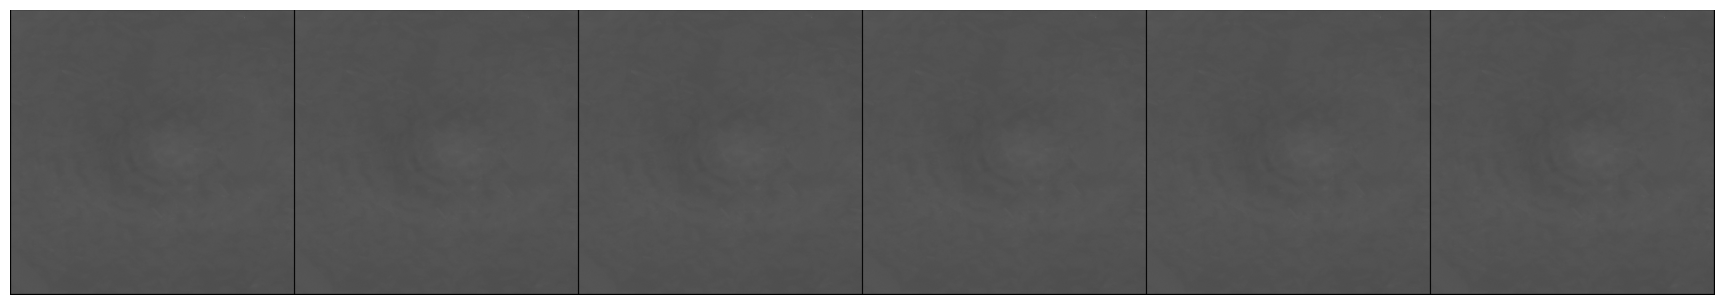

In [8]:
visualize(frame.path.values, np.array(rles), nrow=6, figsize=(22, 12))

In [9]:
# if not config.submission:
#     labels, masks = [], []
#     for index, encoding in enumerate(rles):
#         img = cv2.imread(paths[index], cv2.IMREAD_GRAYSCALE)

#         masks.append(decode(encoding, img.shape))
#         labels.append(decode(frame.rle.values[index], img.shape))

#     masks = torch.from_numpy(np.stack(masks))[:, np.newaxis].byte()
#     labels = torch.from_numpy(np.stack(labels))[:, np.newaxis].byte()

In [10]:
# from angionet.metrics import summary
# print(summary(masks, labels))

In [11]:
submission = pd.DataFrame({"id": ids, "rle": rles})
submission

,id,rle
0,kidney_5_0000,1 0
1,kidney_5_0001,1 0
2,kidney_5_0002,1 0
3,kidney_6_0000,1 0
4,kidney_6_0001,1 0
5,kidney_6_0002,1 0


In [12]:
submission.to_csv("submission.csv", index=False)